<a href="https://colab.research.google.com/github/arthijayaraman-lab/CREASE-2D/blob/main/CREASE%20Tutorials/Calculate_2D_Scattering_Profiles_from_3D_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Change Runtime Environment to use GPUs in Colab while running.
  - Runtime > Change runtime type > Hardware accelarator - T4 GPU.



In [1]:
#@title Download Requirements
!pip install cupy-cuda12x

In [2]:
#@title Import Required libraries
import os
import numpy as np
import pickle
from scipy.special import erfcinv
from scipy.special import i0, i1
from scipy.interpolate import interp1d
import sys
import pandas as pd
import glob
import plotly.express as px
import matplotlib.pyplot as plt
import math
import cupy as cp
from time import time
from time import perf_counter

In [3]:
#@title Calculate 2D scattering profile from 3D structure
structure_file = 'sample_scatterers.dump'
print(f"Downloading input file...")
!wget -O {structure_file} https://raw.githubusercontent.com/arthijayaraman-lab/CREASE-2D/main/CREASE%20Tutorials/sample_scatterers.dump
#@title Compute 2D Scattering profile for generated structure
# Load data
col_types = {'atoms': 'float32', 'id': 'float32', 'type': 'float32', 'x': 'float32', 'y': 'float32', 'z' : 'float32'}
data = pd.read_csv(structure_file,sep='\s+', skiprows=9, header=None, usecols=[0, 1, 2, 3, 4, 5], dtype=col_types)
boxdim = pd.read_csv(structure_file, sep='\s+', dtype=col_types, header=None, skiprows=5, nrows=3)
data = cp.array(data.values)
boxdim = cp.array(boxdim.values)

# Constants
ntheta, qmin_exp, qmax_exp, nq = 91, -2, 3, 501

# Function to process each chunk
def process_chunk(chunk_id, subXYZ, dir1value, dir2value, qmagvalue, boxformfactor_sphere):
    start_time = time()
    currentchunksize = subXYZ.shape[0]
    qposxy = (qmagvalue @ cp.ones((1, currentchunksize))) * ((dir1value @ subXYZ[:, 0].reshape(1, -1)) + (dir2value @ subXYZ[:, 1].reshape(1, -1)))
    qposyz = (qmagvalue @ cp.ones((1, currentchunksize))) * ((dir1value @ subXYZ[:, 1].reshape(1, -1)) + (dir2value @ subXYZ[:, 2].reshape(1, -1)))
    qposxz = (qmagvalue @ cp.ones((1, currentchunksize))) * ((dir1value @ subXYZ[:, 0].reshape(1, -1)) + (dir2value @ subXYZ[:, 2].reshape(1, -1)))

    resultxy = cp.sum(cp.exp(-1j * qposxy) - boxformfactor_sphere * cp.ones((1, currentchunksize), dtype=cp.float32), axis=1)
    resultyz = cp.sum(cp.exp(-1j * qposyz) - boxformfactor_sphere * cp.ones((1, currentchunksize), dtype=cp.float32), axis=1)
    resultxz = cp.sum(cp.exp(-1j * qposxz) - boxformfactor_sphere * cp.ones((1, currentchunksize), dtype=cp.float32), axis=1)

    elapsed_time = time() - start_time
    print(f"Chunk ID: {chunk_id}, Processed in {elapsed_time:.2f} seconds.")
    return resultxy, resultyz, resultxz

# Main calculation function with batch processing
def gpu_calculations_parallel(data_cp, boxdim_cp):
    # Pre-calculation setup (boxlen, boxrad, qgrid, thetagrid, qmag, dir1grid, dir2grid, etc.)
    boxlen = cp.mean(boxdim_cp[:, 1] - boxdim_cp[:, 0])
    boxrad = boxlen / 2

    q_values = cp.logspace(qmin_exp, qmax_exp, nq, dtype=cp.float32)
    theta_values = cp.linspace(0, cp.pi / 2, ntheta, dtype=cp.float32)
    qgrid, thetagrid = cp.meshgrid(q_values, theta_values, indexing='ij')


    qmag = cp.stack((qgrid, qgrid), axis=2)
    qmag = cp.transpose(qmag, (2, 0, 1))

    cos_thetagrid = cp.cos(thetagrid)
    sin_thetagrid = cp.sin(thetagrid)

    dir1grid = cp.stack((cos_thetagrid, -cos_thetagrid), axis=2)
    dir2grid = cp.stack((sin_thetagrid, sin_thetagrid), axis=2)

    a = cp.transpose(dir1grid, (2, 0, 1))
    b = cp.transpose(dir2grid, (2, 0, 1))

    dir1value = cp.concatenate((
        a[0].T.reshape(-1, 1),
        a[1].T.reshape(-1, 1)
    ), axis=0)

    dir2value = cp.concatenate((
        b[0].T.reshape(-1, 1),
        b[1].T.reshape(-1, 1)
    ), axis=0)

    qmagvalue = cp.concatenate((
        qmag[0].T.reshape(-1, 1),
        qmag[1].T.reshape(-1, 1)
    ), axis=0)

    boxformfactor_sphere = 3 * (cp.sin(qmagvalue * boxrad) - (qmagvalue * boxrad) * cp.cos(qmagvalue * boxrad)) / (qmagvalue * boxrad) ** 3


    # Prepare XYZ data
    XYZ = cp.column_stack((data_cp[:, 3], data_cp[:, 4], data_cp[:, 5]))
    XYZ = cp.mod(XYZ + boxrad, boxlen) - boxrad
    datamap = cp.sum(XYZ ** 2, axis=1) < boxrad ** 2
    XYZ = XYZ[datamap, :]
    Numbeads = XYZ.shape[0]

    # Set batch size and calculate number of batches
    batch_size = 1000  # Adjust based on your GPU memory
    num_batches = math.ceil(Numbeads / batch_size)
    # Initialize results
    Ampxy = Ampyz = Ampxz = 0

    # Process each batch
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, Numbeads)
        subXYZ = XYZ[start_idx:end_idx]

        resultxy, resultyz, resultxz = process_chunk(batch, subXYZ, dir1value, dir2value, qmagvalue, boxformfactor_sphere)
        Ampxy += resultxy
        Ampyz += resultyz
        Ampxz += resultxz

    return Ampxy, Ampyz, Ampxz

# Run the GPU calculations with batch processing
Ampxy, Ampyz, Ampxz = gpu_calculations_parallel(data, boxdim)

# Post-calculation processing (reshape and concatenate data)
resultqxqy = cp.log10(cp.abs(Ampxy * cp.conj(Ampxy)))
resultqyqz = cp.log10(cp.abs(Ampyz * cp.conj(Ampyz)))
resultqxqz = cp.log10(cp.abs(Ampxz * cp.conj(Ampxz)))
resultqxqy = resultqxqy.reshape(2, 91, 501)
resultqxqy1 = cp.transpose(resultqxqy[0])
resultqxqy2 = cp.transpose(resultqxqy[1])
resultqyqz = resultqyqz.reshape(2, 91, 501)
resultqyqz1 = cp.transpose(resultqyqz[0])
resultqyqz2 = cp.transpose(resultqyqz[1])
resultqxqz = resultqxqz.reshape(2, 91, 501)
resultqxqz1 = cp.transpose(resultqxqz[0])
resultqxqz2 = cp.transpose(resultqxqz[1])

# Concatenate and flip
dataxy = cp.concatenate([resultqxqy1[:, :-1], cp.fliplr(resultqxqy2[:, :])], axis=1)
datayz = cp.concatenate([resultqyqz1[:, :-1], cp.fliplr(resultqyqz2[:, :])], axis=1)
dataxz = cp.concatenate([resultqxqz1[:, :-1], cp.fliplr(resultqxqz2[:, :])], axis=1)


# Save results
pd.DataFrame(cp.asnumpy(dataxy)).to_csv('samplestructure_dataxy.txt', header=False, index=False)
pd.DataFrame(cp.asnumpy(datayz)).to_csv('samplestructure_datayz.txt', header=False, index=False)
pd.DataFrame(cp.asnumpy(dataxz)).to_csv('samplestructure_dataxz.txt', header=False, index=False)
print("Data saved successfully.")

--2024-12-19 05:12:40--  https://raw.githubusercontent.com/arthijayaraman-lab/CREASE-2D/main/CREASE%20Tutorials/sample_scatterers.dump
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20793826 (20M) [text/plain]
Saving to: ‘sample_scatterers.dump’

sample_scatterers.d 100%[===================>]  19.83M  --.-KB/s    in 0.08s   

2024-12-19 05:12:41 (254 MB/s) - ‘sample_scatterers.dump’ saved [20793826/20793826]

Chunk ID: 0, Processed in 1.74 seconds.
Chunk ID: 1, Processed in 0.00 seconds.
Chunk ID: 2, Processed in 0.00 seconds.
Chunk ID: 3, Processed in 0.00 seconds.
Chunk ID: 4, Processed in 0.00 seconds.
Chunk ID: 5, Processed in 0.00 seconds.
Chunk ID: 6, Processed in 0.00 seconds.
Chunk ID: 7, Processed in 0.00 seconds.
Chunk ID: 8, Processed in 0.00 sec

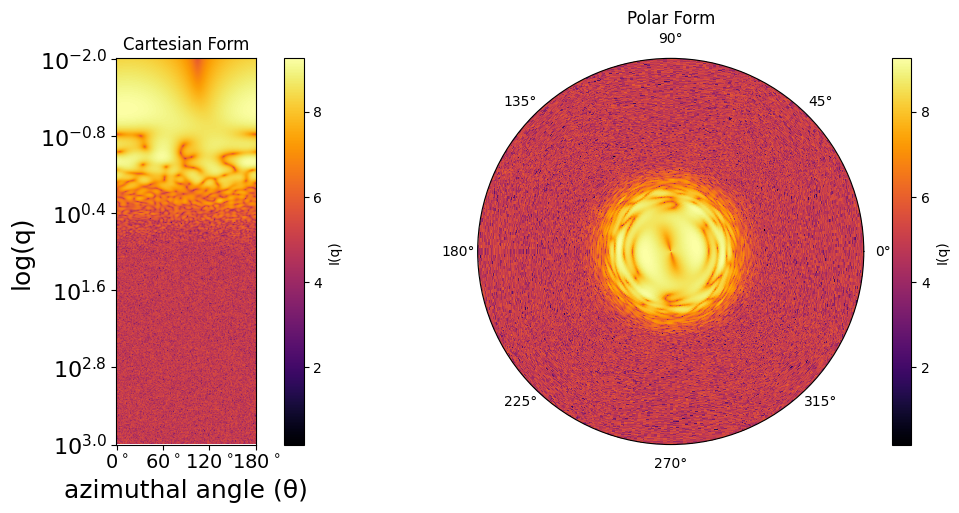

In [4]:
#@title Plot the 2D scattering profile in cartesian and polar form
dataxy_file = '/content/samplestructure_dataxy.txt'
dataxy = np.loadtxt(dataxy_file, delimiter=',')
dataxy_flipped = dataxy[:, ::-1]
dataxy_full = np.hstack((dataxy_flipped, dataxy_flipped))

theta_deg_full = np.linspace(360, 0, dataxy_full.shape[1])
theta_full = np.radians(theta_deg_full)
q = np.arange(dataxy_full.shape[0])
T, Q = np.meshgrid(theta_full, q)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
im_cart = ax1.imshow(dataxy, cmap='inferno')
fig.colorbar(im_cart, ax=ax1, label='I(q)')
ax1.set_title('Cartesian Form')
ax1.set_xlabel("azimuthal angle (θ)", fontsize=18)
ax1.set_ylabel("log(q)", fontsize=18)
x_positions = [0, 60, 120, 181]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0, 100, 200, 300, 400, 501]
y_ticks = ["$10^{-2.0}$", "$10^{-0.8}$", "$10^{0.4}$", "$10^{1.6}$", "$10^{2.8}$", "$10^{3.0}$"]
ax1.set_xticks(x_positions)
ax1.set_xticklabels(x_ticks, fontsize=14)
ax1.set_yticks(y_positions)
ax1.set_yticklabels(y_ticks, fontsize=16)
ax2 = fig.add_subplot(1, 2, 2, projection='polar')
im_polar = ax2.pcolormesh(T, Q, dataxy_full,cmap='inferno')
ax2.set_theta_zero_location("E")
ax2.set_theta_direction(1)
ax2.set_title('Polar Form')
ax2.grid(False)
ax2.set_rticks([])
fig.colorbar(im_polar, ax=ax2, label='I(q)')
plt.tight_layout()
plt.show()